<a href="https://colab.research.google.com/github/feneto/Projeto-Transfer_Learning_para_Classificacao_de_Imagens/blob/main/Projeto_Transfer_Learning_para_Classificacao_de_Imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Projeto: Transfer Learning para Classificação de Imagens

Este projeto utiliza a técnica de Transfer Learning para otimizar o treinamento de um modelo de classificação de imagens, destacando sua eficiência em cenários com recursos computacionais limitados.

Do 'Kaggle Cats and Dogs Dataset' (https://www.microsoft.com/en-us/download/details.aspx?id=54765), serão selecionadas automaticamente 1.000 imagens de gatos e 1.000 de cachorros, totalizando 2.000 das 25.000 imagens disponíveis. Inicialmente, o modelo será treinado do zero com essas imagens para estabelecer uma baseline de desempenho.

Em seguida, com base no 'Notebook de Transfer Learning de Kyle Mathewson' (https://colab.research.google.com/github/kylemath/ml4a-guides/blob/master/notebooks/transfer-learning.ipynb), aplicaremos a técnica de Transfer Learning utilizando o modelo pré-treinado VGG16 (vencedor do ImageNet Challenge em 2014), ajustando-o com o mesmo conjunto de dados.

Os resultados obtidos demonstrarão que o Transfer Learning pode alcançar maior acurácia em menos tempo, evidenciando sua relevância para problemas práticos e otimizando o uso de recursos computacionais.

Import necessary libraries and frameworks:

In [ ]:
%matplotlib inline

import os

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from PIL import Image, UnidentifiedImageError

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

Download and uncompress the dataset if it doesn't already exist:

In [ ]:
!if [ ! -f "kagglecatsanddogs_5340.zip" ]; then \
    curl -L -o "kagglecatsanddogs_5340.zip" --progress-bar "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"; \
fi

# Extract the dataset and count the total number of files
!unzip -qn "kagglecatsanddogs_5340.zip"
!ls -lR ./PetImages | grep -v '^d' | wc -l

# Limit the dataset to 1000 images per class to avoid overloading memory
!find ./PetImages/Cat -type f -print0 | sort -zR | tail -zn +1001 | xargs -0 rm
!find ./PetImages/Dog -type f -print0 | sort -zR | tail -zn +1001 | xargs -0 rm

# Verify the remaining number of images
!ls -lR ./PetImages | grep -v '^d' | wc -l

############################################################################################# 100.0%
25010
2008


Load all the image data for pre-processing:

In [ ]:
root = 'PetImages'
train_split, val_split = 0.7, 0.15

# Extract categories (subdirectories) under the root folder
categories = [x[0] for x in os.walk(root) if x[0]][1:]

print(categories) # Print detected categories (e.g., Cats, Dogs)

['PetImages/Cat', 'PetImages/Dog']


Function to preprocess image data: resizing, RGB conversion, and vectorization:

In [ ]:
def get_image(path):
    with Image.open(path) as img:
        if img.mode != 'RGB':
            img = img.convert('RGB') # Ensure the image is in RGB format

        img = img.resize((224, 224))  # Resize to a consistent shape

        x = np.array(img) # Convert to NumPy array

        x = np.expand_dims(x, axis=0) # Add batch dimension
        x = preprocess_input(x) # Apply preprocessing

        return img, x

Load and validate all images from the dataset folder:

In [ ]:
data = []
invalid_images = []

for c, category in enumerate(categories): # Iterate over categories (e.g., Cats, Dogs)
    images = [
        os.path.join(dp, f)
        for dp, dn, filenames in os.walk(category)
        for f in filenames
        if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg'] # Filter image files
    ]

    for img_path in images:
        try:
            with Image.open(img_path) as img:
                img.verify()  # Check for corrupted files

            img, x = get_image(img_path) # Preprocess the image
            data.append({'x': np.array(x[0]), 'y': c}) # Add image and label to data list
        except (UnidentifiedImageError, OSError, ValueError) as e: # Handle invalid images

            print(f"Error validating or processing image: {img_path}. Details: {e}")
            invalid_images.append(img_path)
            try:
                os.remove(img_path) # Remove invalid files
                print(f"Invalid image removed: {img_path}")
            except Exception as delete_error:
                print(f"Error while trying to delete image {img_path}: {delete_error}")
            continue

num_classes = len(categories) # Calculate the number of classes (categories)

print(f"Total successfully processed images: {len(data)}")

Total successfully processed images: 2000


Shuffle the dataset to ensure randomness:

In [ ]:
random.shuffle(data)

Create splits for training (70%), validation (15%), and testing (15%):

In [ ]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data and labels into distinct arrays:

In [ ]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1]


Normalize image data and convert labels to categorical format:

In [ ]:
x_train = x_train.astype('float32') / 255. # Normalize pixel values
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

y_train = keras.utils.to_categorical(y_train, num_classes) # One-hot encode labels
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(300, 2)


Display dataset summary:

In [ ]:
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)

finished loading 2000 images from 2 categories
train / validation / test split: 1400, 300, 300
training data shape:  (1400, 224, 224, 3)
training labels shape:  (1400, 2)


Display random sample images from the dataset:

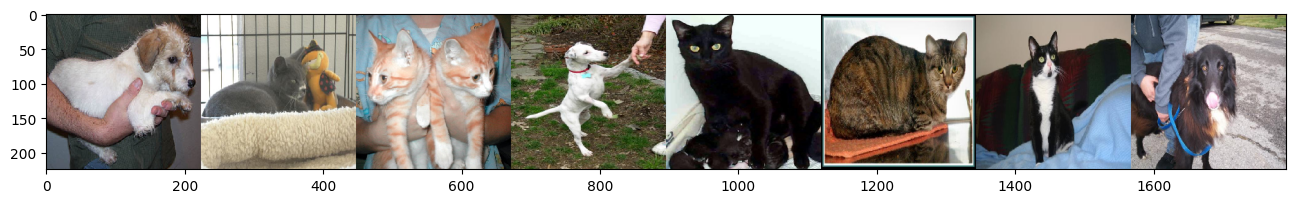

In [ ]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Build a sequential CNN model:


In [ ]:
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:])) # First convolutional layer
model.add(Activation('relu')) # Activation function
model.add(MaxPooling2D(pool_size=(2, 2))) # Max-pooling layer

model.add(Conv2D(32, (3, 3))) # Second convolutional layer
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25)) # Dropout for regularization

model.add(Conv2D(32, (3, 3)))  # Third convolutional layer
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))  # Fourth convolutional layer
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25)) # Dropout for regularization

model.add(Flatten()) # Flatten the input
model.add(Dense(256)) # Fully connected layer
model.add(Activation('relu'))

model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(num_classes)) # Output layer
model.add(Activation('softmax')) # Softmax for classification

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

Compile and train the model:

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.5382 - loss: 0.6948 - val_accuracy: 0.4800 - val_loss: 0.7208
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5739 - loss: 0.6769 - val_accuracy: 0.6333 - val_loss: 0.6313
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.6225 - loss: 0.6415 - val_accuracy: 0.6600 - val_loss: 0.6206
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6595 - loss: 0.6172 - val_accuracy: 0.6700 - val_loss: 0.6117
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.6607 - loss: 0.6031 - val_accuracy: 0.6600 - val_loss: 0.6053
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 146s 2s/step - accuracy: 0.6807 - loss: 0.5901 - val_accuracy: 0.6767 - val_loss: 0.5969
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.7341 - loss: 0.5555 - val_accuracy: 0.7233 - val_loss: 0.5816
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.7604 - loss: 0.4955 - val_accuracy: 0.7267 - v

Plot validation loss and accuracy during training:

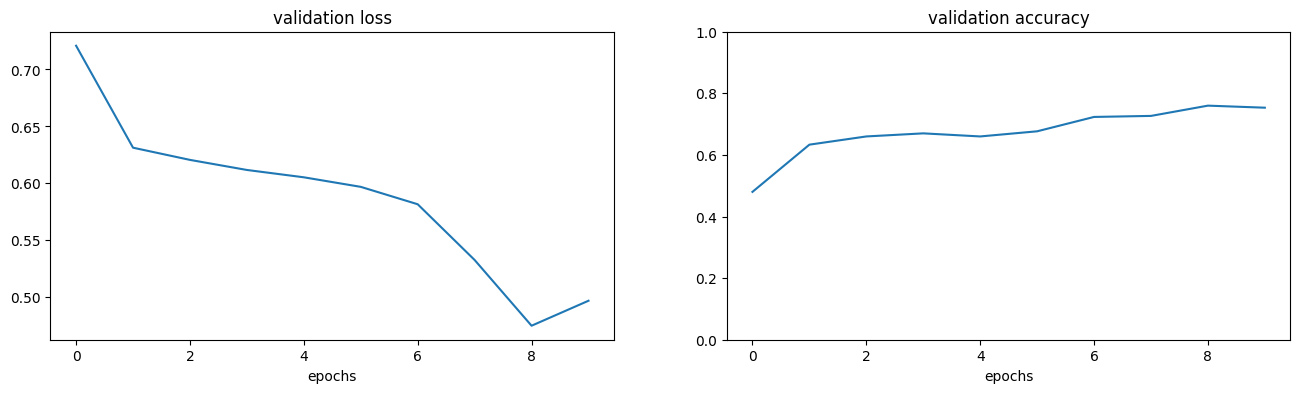

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Evaluate the model on the test set:

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.6498126983642578
Test accuracy: 0.6966666579246521


Load pre-trained VGG16 model for transfer learning:

In [ ]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

Modify VGG16 by adding a new classification layer for our specific dataset:

In [ ]:
inp = vgg.input
new_classification_layer = Dense(num_classes, activation='softmax')
out = new_classification_layer(vgg.layers[-2].output)
model_new = Model(inp, out)

Freeze all layers except the last classification layer:

In [ ]:
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

Train the modified VGG16 model:

In [ ]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=32,
                         epochs=10,
                         validation_data=(x_val, y_val))

Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1045s 24s/step - accuracy: 0.6308 - loss: 0.7169 - val_accuracy: 0.8800 - val_loss: 0.3412
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1064s 23s/step - accuracy: 0.8751 - loss: 0.3384 - val_accuracy: 0.9000 - val_loss: 0.2678
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1037s 23s/step - accuracy: 0.9018 - loss: 0.2679 - val_accuracy: 0.8967 - val_loss: 0.2728
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1076s 24s/step - accuracy: 0.8977 - loss: 0.2652 - val_accuracy: 0.8133 - val_loss: 0.3704
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1015s 23s/step - accuracy: 0.8473 - loss: 0.3203 - val_accuracy: 0.8500 - val_loss: 0.3053
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1068s 24s/step - accuracy: 0.8988 - loss: 0.2420 - val_accuracy: 0.9167 - val_loss: 0.1965
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1008s 23s/step - accuracy: 0.9190 - loss: 0.2035 - val_accuracy: 0.9167 - val_loss: 0.2110
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1045s 23s/step - accuracy: 0.9130 - loss: 0.2121 - val_accu

Plot validation loss and accuracy for both models:

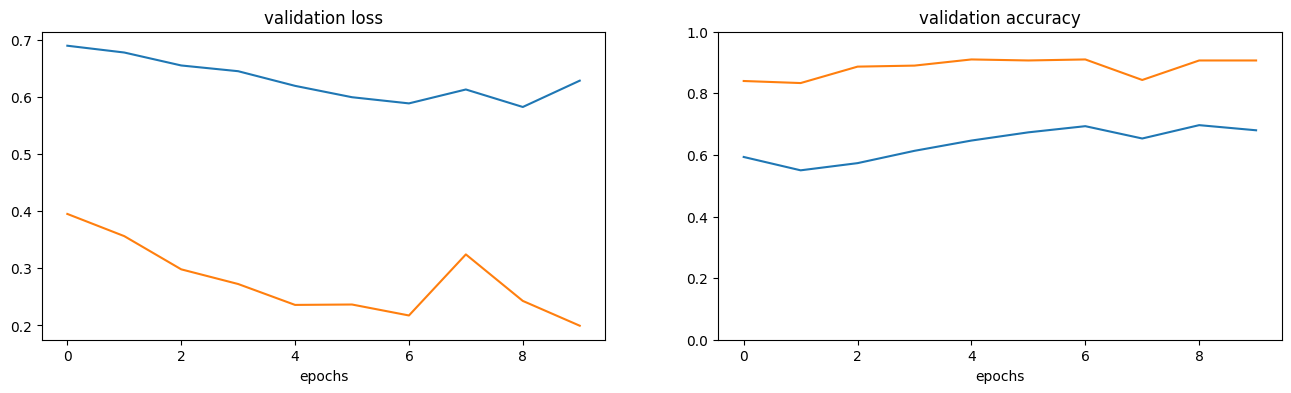

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Final evaluation on the test set for the transfer learned model:

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.17981158196926117
Test accuracy: 0.9200000166893005


Predict a class for a random image from the dataset:

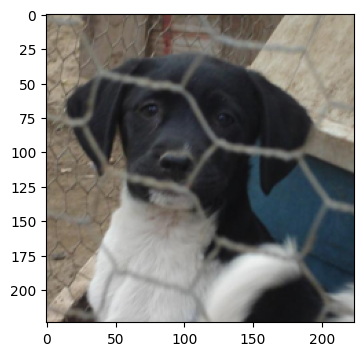

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted class: PetImages/Dog (ID: 1)
Confidence: 1.00000


In [ ]:
random_img_path = !find ./PetImages/Cat ./PetImages/Dog -type f -name '*.jpg' -print0 | shuf -z -n 1
random_img_path = random_img_path[0].replace('\x00', '') # Select random image
img, x = get_image(random_img_path) # Preprocess the image

plt.figure(figsize=(16, 4))
plt.imshow(np.asarray(img)) # Display the image
plt.show()

probabilities = model_new.predict(x) # Predict class probabilities

predicted_class = np.argmax(probabilities[0]) # Determine the most probable class
confidence = probabilities[0][predicted_class] # Calculate confidence

print(f"Predicted class: {categories[predicted_class]} (ID: {predicted_class})")
print(f"Confidence: {confidence:.5f}")
